# Python basemap plot bathymetry example

This .nb is designed to provide a guide to generating bathymetric plots using basemap.  It is written using the Anaconda Python Scientific Package found here [Continuum Anaconda Download](https://store.continuum.io/cshop/anaconda/).   

Additionally, you will need the `Basemap` package, not included in Anaconda but easily obtained using their package manager and `netCDF4` which is contained in the anaconda linux and OSX distributions but not the windows version (try [Pythonxy](https://code.google.com/p/pythonxy/) if you are a windows user... many of the same tools exist in the windows conda python installation but not all... you may need to find alternatives.

## Setting up your environment

You can get Basemap via `Conda` - the package manager for Anaconda Python

Open a terminal window and type:   

    conda install basemap
    
    

## Ipython notebook magic command

The following command will allow matplotlib to generate images in the notebook (as opposed to in a seperate window)

In [1]:
%matplotlib inline

### Basic Program setup

Start with your `shebang` line which locates the version of python you are running (only really important if you keep multiple versions on your machine)

I always like to add a header section which specifies the name and purpose of the program as well as any large scale information I believe should be included.  By containing these in `"""` (triplet of double quotes) the information is available in many python development environments, recognized as a docstring (see python documentation for more details).

In [2]:
#!/usr/bin/env

"""
 Smith_bathymetry_example.py

 Bathymetry comparison for smith and etopo5

 Using Anaconda packaged Python
"""

'\n Smith_bathymetry_example.py\n\n Bathymetry comparison for smith and etopo5\n\n Using Anaconda packaged Python\n'

The next section specifies any included modules or packages that will need to be called in the program.  It is best practice to place all imports at the start of the program.  I am importing:   

+ datetime - a standard package for gathering date and time from the local machine
+ numpy - the numerical python package for array mathematics
+ netCDF4 - a module for handling the NetCDF file type (not included in the windows version of Anaconda)
+ matplotlib - the matlab like plotting library
+ basemap - the map plotting library

(I am glossing over the differences in import syntax for this notebook)

Finally, I specify some program variables that pertain specifically to the module being run (basically program metadata)

In [3]:
#System Stack
import datetime

#Science Stack
import numpy as np
from netCDF4 import Dataset


# Visual Stack
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

__author__   = 'Shaun Bell'
__email__    = 'shaun.bell@noaa.gov'
__created__  = datetime.datetime(2014, 01, 13)
__modified__ = datetime.datetime(2014, 01, 13)
__version__  = "0.1.0"
__status__   = "Development"
__keywords__ = 'ETOPO5','SMITH','bathymetry'

### Reading in the data

#### Etopo5 Dataset

The data readin aspect is written as in-program subroutines/modules for simplicity of code.  The following two methods are quite redundant as they both read in topographical data from a netcdf dataset.  In order to save memory space boundaries to the data are set prior to readin based on maximum latitude and longitude.  However, longitude definitions vary among different data sets.  In this case the `etopo5` data spans from `0-->360` with positive being East while the Smith dataset spans `-180-->180` with positive also being East.   


In [4]:
"""------------------------ Read Data Modules-------------------------------------------"""

def etopo5_data(file='etopo5.nc'):
    """
    readin etopo5 dataset
    inputs: full path to dataset
    
    outputs:    latitudes - array like
                longitudes - array like
                topo - array like
                
    File is small enough that entire data set could be read in at once if wanted            
    """
                
    #netcdf4 utility to open the .nc file
    etopodata = Dataset(file)
    
    #read in only the lat and lon first
    lons = etopodata.variables['X'][:]
    lats = etopodata.variables['Y'][:]

    ### use boundaries to limit input data
    # etopo5 longitudes run from 0-360 (+ East)
    # find appropriate indices
    lats_ind = (lats >= 45.) & (lats <=65.)
    lats_ind = np.where(lats_ind)[0]
    lons_ind = (lons >= -0.001)
    lons_ind = np.where(lons_ind)[0]

    lats = lats[lats_ind]
    lons = lons[lons_ind]
    
    #read in limited longitudes
    topoin = etopodata.variables['bath'][lats_ind,lons_ind]
    
    #close nc file
    etopodata.close()

    #shift grid so that it runs from -360->0 (locations in GOA are negative eg -140)
    topoin,lons = shiftgrid(0.,topoin,lons,start=False) # -360 -> 0

    #create grid of lats and lons
    lons, lats = np.meshgrid(lons, lats)

    #return latitudes, longitudes and select topo info
    return(topoin, lats, lons)

#### And for the Smith 2004 Dataset:

We will do the exact same method but change the hard coded boundaries. The Etopo5 data needed to be shifted so that our region's negative latitude (since it is in the western hemisphere) remains consistent otherwise we would need to calculate the equivalent latitude for the etopo dataset such that our region was within the defined boundaries.  Smith is set up so that this is not necessary so there is no grid shifting taking place.

In [5]:
def smith_data(file='smith_2004.nc'):
    """ 
    read in Smith 2004 topography/bathymetry.
    inputs: full path to dataset
    
    outputs:    latitudes - array like
                longitudes - array like
                topo - array like
                
    Note: File is very large, don't try to read it all in at once            
    """
    
    smith_topo = Dataset(file)

    lons = smith_topo.variables['LONGITUDE'][:]
    lats = smith_topo.variables['LATITUDE'][:]

    ### use boundaries to limit input data
    lats_ind = (lats >= 45.) & (lats <=65.)
    lats_ind = np.where(lats_ind)[0]
    lons_ind = (lons <= -90.001)
    lons_ind = np.where(lons_ind)[0]

    lats = lats[lats_ind]
    lons = lons[lons_ind]
    topoin = smith_topo.variables['ROSE'][lats_ind,lons_ind]
    smith_topo.close()

    #no need to shift the longitudes as western longitudes are already negative
    #topoin,lons = shiftgrid(0.,topoin,lons,start=False) # -360 -> 0


    lons, lats = np.meshgrid(lons, lats)

    return(topoin, lats, lons)

### The Main Routine

In [7]:
"""---------------------------- Main Routine-------------------------------------------"""

#call functions specified above
(etopoin, elats, elons) = etopo5_data(file='data/etopo5.nc')
(stopoin, slats, slons) = smith_data(file='data/smith_2004.nc')

Start a matplot lib figure instance.  Two axis will be generated side-by-side via 
> `ax = plt.subplot(121)`

Call a Basemap instance: required inputs are:   

* resolution - the resolution of the boundaries and borders ('i' is intermediate)
* projection - the map projection ('merc' is mercator)
* the remaining inputs are boundaries based on the projection and can vary depending on the projection chosen

_(For more help on Basemap goto http://matplotlib.org/basemap/api/basemap_api.html)_

> `m = Basemap()`

All future ploting routines will add to the `m` basemap instance

> `ex, ey = m(elons, elats)`

_converts the lats and lons to the map projection grid_

> `levels`

_specifies an array with the values we wish to contour_

> `m.contour()` 

_basemap call that plots the contours_

> ` m.drawcontries()
    m.drawcostlines()
    m.drawparallels()
    m.drawmeridians()
    m.fillcontinents()
    m.drawmapscale()`
    
_these basemap routines should be straightforward, see the docs for parameters and deffinitions_

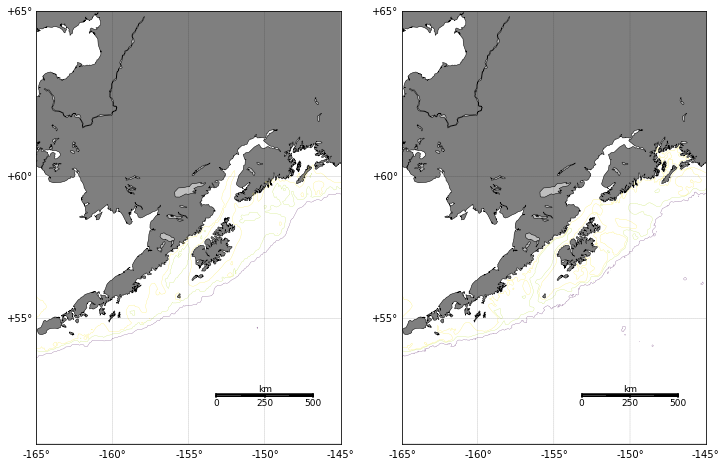

In [8]:
fig = plt.figure()
ax = plt.subplot(121)

#instantiate basemap
#resolution specifies the level of coastal boundaries and the like, projection is the map type 
#  and the rest specify the map boundaries
m = Basemap(resolution='i',projection='merc', llcrnrlat=50, \
	urcrnrlat=65,llcrnrlon=-165,urcrnrlon=-145, lat_ts=45)

#ETOPO 5 contour data
ex, ey = m(elons, elats)
#contour the 1000, 200, and 100 depths
levels = [-1000, -200, -100]
CS = m.contour(ex,ey,etopoin, levels=levels, linewidths=0.2)
#uncomment the following line to label the contour levels
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

#draw extra features such as countries
m.drawcountries(linewidth=0.5)
#coastlines
m.drawcoastlines(linewidth=0.5)
#meridians and parallels
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
m.fillcontinents(color='black', alpha=.5)
#map scale
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

ax = plt.subplot(122)

#SMITH contour data
sx, sy = m(slons, slats)
levels = [-1000, -200, -100]
CS = m.contour(sx,sy,stopoin, levels=levels, linewidths=0.2)
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
m.fillcontinents(color='black', alpha=.5)
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )

plt.show()
#save the image as a .png - specified by the file ending
#plt.savefig('images/ETOPO5vSMITH.png', bbox_inches='tight', dpi = (100))
#plt.close()

How about something a little more aesthetic... 

lets use the terrain colorbar (plt.cm.terrain or plt.cm.gist_earth) and contour fill our data (and lets show the topography of the land as well while we are at it)

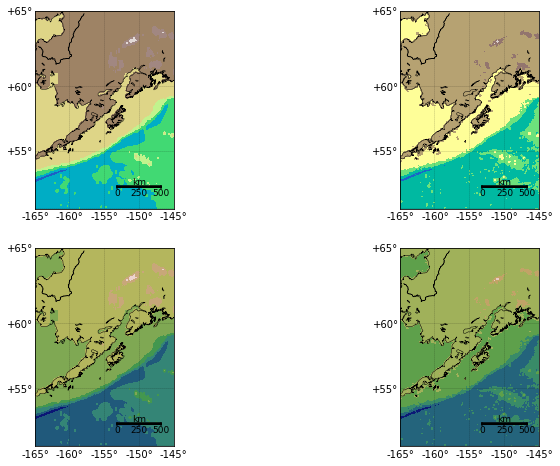

In [16]:
fig = plt.figure()

#
# use plt.cm.terrain
#
ax = plt.subplot(221)

#instantiate basemap
#resolution specifies the level of coastal boundaries and the like, projection is the map type 
#  and the rest specify the map boundaries
m = Basemap(resolution='i',projection='merc', llcrnrlat=50, \
	urcrnrlat=65,llcrnrlon=-165,urcrnrlon=-145, lat_ts=45)

#ETOPO 5 contour data
ex, ey = m(elons, elats)
#contour the 1000, 200, and 100 depths
levels = np.arange(-6000,6000,100)
CS = m.contourf(ex,ey,etopoin, cmap=plt.cm.terrain, linewidths=0.2)
#uncomment the following line to label the contour levels
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

#draw extra features such as countries
m.drawcountries(linewidth=0.5)
#coastlines
m.drawcoastlines(linewidth=0.5)
#meridians and parallels
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
#map scale
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

ax = plt.subplot(222)

#SMITH contour data
sx, sy = m(slons, slats)
levels = np.arange(-6000,6000,100)
CS = m.contourf(sx,sy,stopoin, cmap=plt.cm.terrain, linewidths=0.2)
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )

#
# use plt.cm.gist_earth
#
ax = plt.subplot(223)

#instantiate basemap
#resolution specifies the level of coastal boundaries and the like, projection is the map type 
#  and the rest specify the map boundaries
m = Basemap(resolution='i',projection='merc', llcrnrlat=50, \
	urcrnrlat=65,llcrnrlon=-165,urcrnrlon=-145, lat_ts=45)

#ETOPO 5 contour data
ex, ey = m(elons, elats)
#contour the 1000, 200, and 100 depths
levels = np.arange(-6000,6000,100)
CS = m.contourf(ex,ey,etopoin, cmap=plt.cm.gist_earth, linewidths=0.2)
#uncomment the following line to label the contour levels
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

#draw extra features such as countries
m.drawcountries(linewidth=0.5)
#coastlines
m.drawcoastlines(linewidth=0.5)
#meridians and parallels
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
#map scale
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

ax = plt.subplot(224)

#SMITH contour data
sx, sy = m(slons, slats)
levels = np.arange(-6000,6000,100)
CS = m.contourf(sx,sy,stopoin, cmap=plt.cm.gist_earth, linewidths=0.2)
#plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f')

m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(45,71,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(-165,-144,5.),labels=[1,0,0,1],color='black',dashes=[1,1],\
	labelstyle='+/-',linewidth=0.2) # draw meridians
m.drawmapscale(-150, 52, -157, 57, 500, barstyle='fancy', units='km', yoffset=10000)

#DefaultSize = fig.get_size_inches()
#fig.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
plt.show()
#save the image as a .png - specified by the file ending
#plt.savefig('images/ETOPO5vSMITH.png', bbox_inches='tight', dpi = (100))
#plt.close()